In [1]:
__author__: "Matt Canrey"
__date__ : "20220816"
__stage__: "Dev"
__Version__: "0.0.1"

## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from graphviz import Source
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from re import sub



## Directory

In [4]:
# Configure root, src, and data filepaths
fp_root = os.getcwd().replace('src', '')
fp_src = os.path.join(fp_root, 'src')
fp_data = os.path.join(fp_root, 'data')

## Import Data

In [5]:
# Import adult income data
income_csv = os.path.join(fp_data, 'adult.csv')
df_income = pd.read_csv(income_csv)

## Cleaning and EDA

In [6]:
df_income.shape
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [7]:
# Check for NAs - No NAs
#for i in df_income.columns:
#    print(i, df_income[i].isna().sum())

<AxesSubplot:>

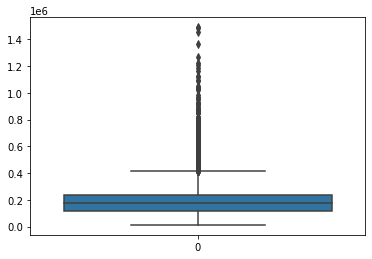

In [8]:
sns.boxplot(data=df_income['fnlwgt'])

In [9]:
# Remove outliers
num_cols = df_income.select_dtypes(int).columns
for col in num_cols:
    nine_five =  df_income[col].quantile(0.95)
    five = df_income[col].quantile(0.05)
    df_income = df_income[(df_income[col] <= nine_five) | (df_income[col] <= five)]


## Pre-processing

In [10]:
import category_encoders as ce

In [11]:
# Categorical Encoding
# Create binary target variable
gender_dict = {'Male': 1,
               'Female': 0}
df_income['gender'] = df_income['gender'].map(gender_dict)

# Target encode categorical features
cat_cols = df_income.select_dtypes(include='object').columns
target_enc = ce.TargetEncoder()
df_icnome_cat = target_enc.fit_transform(df_income[cat_cols], df_income['gender'])
df_income[cat_cols] = df_icnome_cat


In [12]:
# Train test split
# Target and features
y = df_income['gender']
X = df_income.drop(columns= 'gender')


# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=123, stratify=y)


## Baseline Modeling

In [13]:
def baseline_models(X_train, y_train, cv=5):
        """
        Inputs: Feature training data, target training data
        Outputs: Dataframe of baseline model performance from models
        """
        # Metrics
        metrics = ['accuracy', 'roc_auc']

        # Transformers
        #scaler = StandardScaler()

        # Models
        dt = DecisionTreeClassifier(random_state=123)
        rf = RandomForestClassifier(random_state=123)
        gb = GradientBoostingClassifier(random_state=123)
        baseline_models =  [('Decision Tree Classifier', dt),
                        ('Random Forest Classifier', rf),
                        ('Gradient Boosting Classifier', gb)]

        # Create dataframe to aggregate performance
        cols = ['Model', 'Fit Time', 'Train accuracy', 'Test accuracy', 'Train ROC AUC', 'Test ROC AUC']
        df_baseline = pd.DataFrame(columns=cols)

        # Pipeline
        pipelines = []

        for model_name, model in baseline_models:
                pipeline = Pipeline(steps=[
                                #('transfomer', scaler),
                                ('models', model)])

                cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring = metrics, return_train_score=True)
                
                vals = [model_name, cv_results['fit_time'].mean(),
                        cv_results['train_accuracy'].mean(), 
                        cv_results['test_accuracy'].mean(),
                        cv_results['train_roc_auc'].mean(),
                        cv_results['test_roc_auc'].mean()]
                
                df_baseline.loc[len(df_baseline)] = vals
        
                pipelines.append(pipeline)
        #print(f"{model_name} complete")
        return df_baseline, pipelines

In [14]:
# Run Model
df_baseline, pipes = baseline_models(X_train, y_train)

In [15]:
df_baseline

,Model,Fit Time,Train accuracy,Test accuracy,Train ROC AUC,Test ROC AUC
0,Decision Tree Classifier,0.065467,1.000000,0.794829,1.000000,0.775842
1,Random Forest Classifier,1.423410,1.000000,0.834674,1.000000,0.922324
2,Gradient Boosting Classifier,1.803560,0.842466,0.837831,0.931447,0.927626


In [16]:
pipes

[Pipeline(steps=[('models', DecisionTreeClassifier(random_state=123))]),
 Pipeline(steps=[('models', RandomForestClassifier(random_state=123))]),
 Pipeline(steps=[('models', GradientBoostingClassifier(random_state=123))])]

In [17]:
def plot_learning_curve(X_train, y_train, model):
    """
    Plots learning curve for model
    """
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv = None, scoring='accuracy',train_sizes = np.linspace(0.1, 1.0, 10))

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(0)
    plt.gcf().set_facecolor('white')
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label= 'Training Accuracy')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, label= 'Testing Accuracy')
    plt.title('Learning Curve')
    plt.xlabel('Training Data Size')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend(loc='lower right')

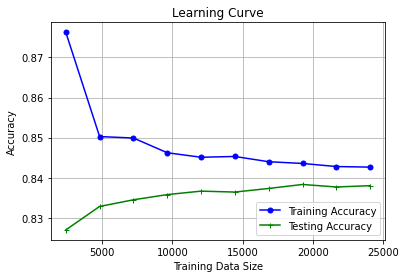

In [19]:
plot_learning_curve(X_train, y_train, pipes[2])

## Model Assessment

In [20]:
# Select model for test set
selected_model = pipes[2]
selected_model.fit(X_train, y_train)

Pipeline(steps=[('models', GradientBoostingClassifier(random_state=123))])

In [21]:
# Final performance metrics
y_pred = selected_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

0.8380965040542336

[Text(0.5, 1.0, 'ConnectionResetErrorPermutation Importances (test set)'),
 Text(0.5, 0, 'Decrease in accuracy score'),
 Text(0, 0.5, 'Feature')]

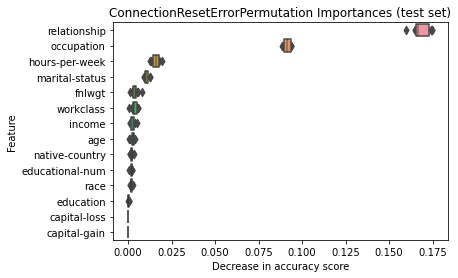

In [22]:
# Feature Importance
result = permutation_importance(
    selected_model, X_test, y_test, scoring = 'accuracy', n_repeats=10, random_state=123, n_jobs=2)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

cols = list(importances.columns)
cols.reverse()

plt.gcf().set_facecolor('white')
sns.boxenplot(data=importances, orient='h', order = cols).set(title = 'ConnectionResetErrorPermutation Importances (test set)', 
                                                                        xlabel= 'Decrease in accuracy score',
                                                                        ylabel= 'Feature')

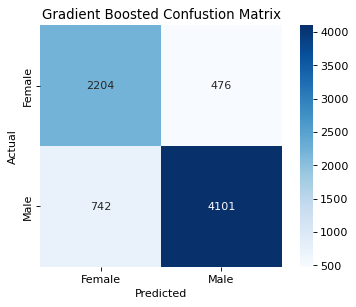

In [23]:
# Confusion matrix heat map
# Confusion Matrix
cv_confusion = confusion_matrix(y_test, y_pred)

plt.figure(dpi=80)
sns.heatmap(cv_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt="d",
           xticklabels=['Female', 'Male'],
           yticklabels=['Female', 'Male'])
plt.gcf().set_facecolor('white')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boosted Confustion Matrix');

In [24]:
#Generate data frame of model test statistics
y_probs = selected_model.predict_proba(X_test)[:,1]
thresholds = []
f1 = []
precisions = []
recall = []
tn = []
fp = []
fn = []
tp = []

for t in range(0,105,10):
    y_pred = pd.Series(y_probs).apply(lambda x: 0 if x<t/100 else 1)
    thresholds.append(t/100)
    f1.append(f1_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    tn.append(confusion_matrix(y_test, y_pred)[0][0])
    fp.append(confusion_matrix(y_test, y_pred)[0][1])
    fn.append(confusion_matrix(y_test, y_pred)[1][0])
    tp.append(confusion_matrix(y_test, y_pred)[1][1])
    

test_statistics = pd.DataFrame(
    {'Threshold': thresholds,
     'F1 Score' : f1,
     'Precision': precisions,
     'Recall' : recall,
     'True_Negative': tn,
     'False_Positive': fp,
     'False_Negative': fn,
     'True_Positive': tp,
    })

test_statistics

c:\Users\mcarney\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Threshold,F1 Score,Precision,Recall,True_Negative,False_Positive,False_Negative,True_Positive
0,0.0,0.783277,0.643759,1.000000,0,2680,0,4843
1,0.1,0.824998,0.703968,0.996283,651,2029,18,4825
2,0.2,0.844192,0.741105,0.980591,1021,1659,94,4749
3,0.3,0.858755,0.777815,0.958497,1354,1326,201,4642
4,0.4,0.871517,0.832894,0.913896,1792,888,417,4426
5,0.5,0.870701,0.896002,0.846789,2204,476,742,4101
6,0.6,0.852961,0.937856,0.782160,2429,251,1055,3788
7,0.7,0.838371,0.964037,0.741689,2546,134,1251,3592
8,0.8,0.820881,0.976917,0.707826,2599,81,1415,3428
9,0.9,0.778098,0.989484,0.641132,2647,33,1738,3105


Text(0.5, 0, 'Threshold')

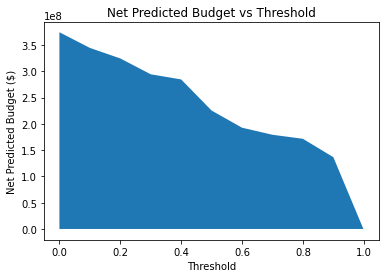

In [127]:
plt.stackplot(areaplot['Threshold'], areaplot['Over Budget'])
plt.title('Net Predicted Budget vs Threshold')
plt.ylabel('Net Predicted Budget ($)')
plt.xlabel('Threshold')

In [128]:
areaplot = test_statistics[['Threshold', 'False_Positive', 'False_Negative', 'True_Positive']]
areaplot['Predicted Cost'] = (test_statistics['False_Positive'] + test_statistics['True_Positive']) *50000
areaplot['Actual Cost'] = (test_statistics['False_Negative'] + test_statistics['True_Positive']) * 50000
#areaplot['Actual Cost'] = (180000 - areaplot['Predicted Cost'])
areaplot['Over Budget'] = areaplot['Predicted Cost'] - 1800000
#areapl = areaplot[['Threshold', 'Predicted Cost', 'Actual Cost']]

C:\Users\mcarney\AppData\Local\Temp/ipykernel_18988/200036397.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  areaplot['Predicted Cost'] = (test_statistics['False_Positive'] + test_statistics['True_Positive']) *50000
C:\Users\mcarney\AppData\Local\Temp/ipykernel_18988/200036397.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  areaplot['Actual Cost'] = (test_statistics['False_Negative'] + test_statistics['True_Positive']) * 50000
